Type in grid_size: 30
Type in sound_radius: 30
Enter robot's starting X position (0-29): 15
Enter robot's starting Y position (0-29): 15


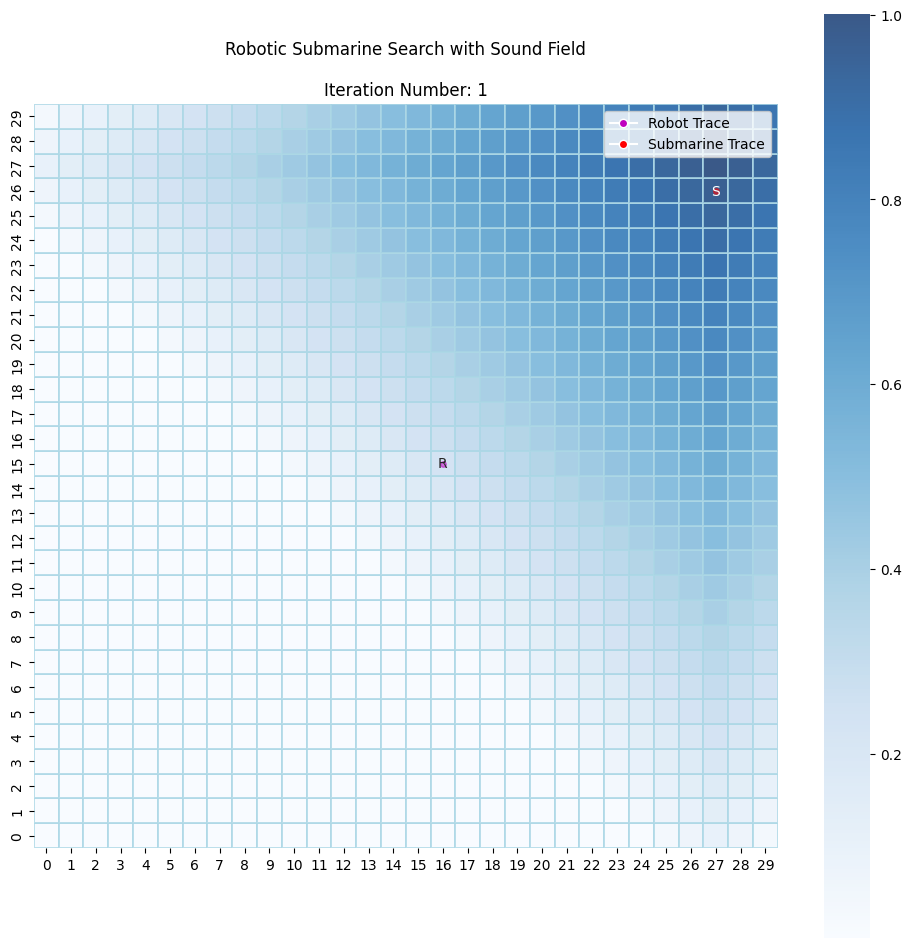

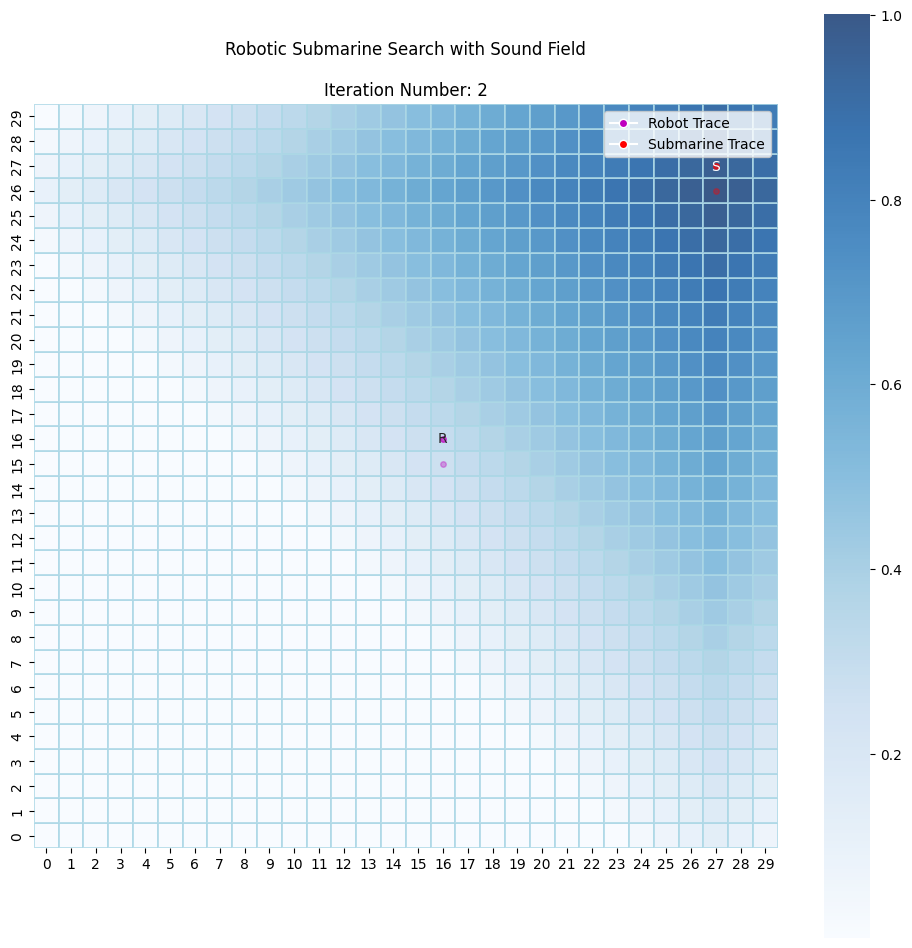

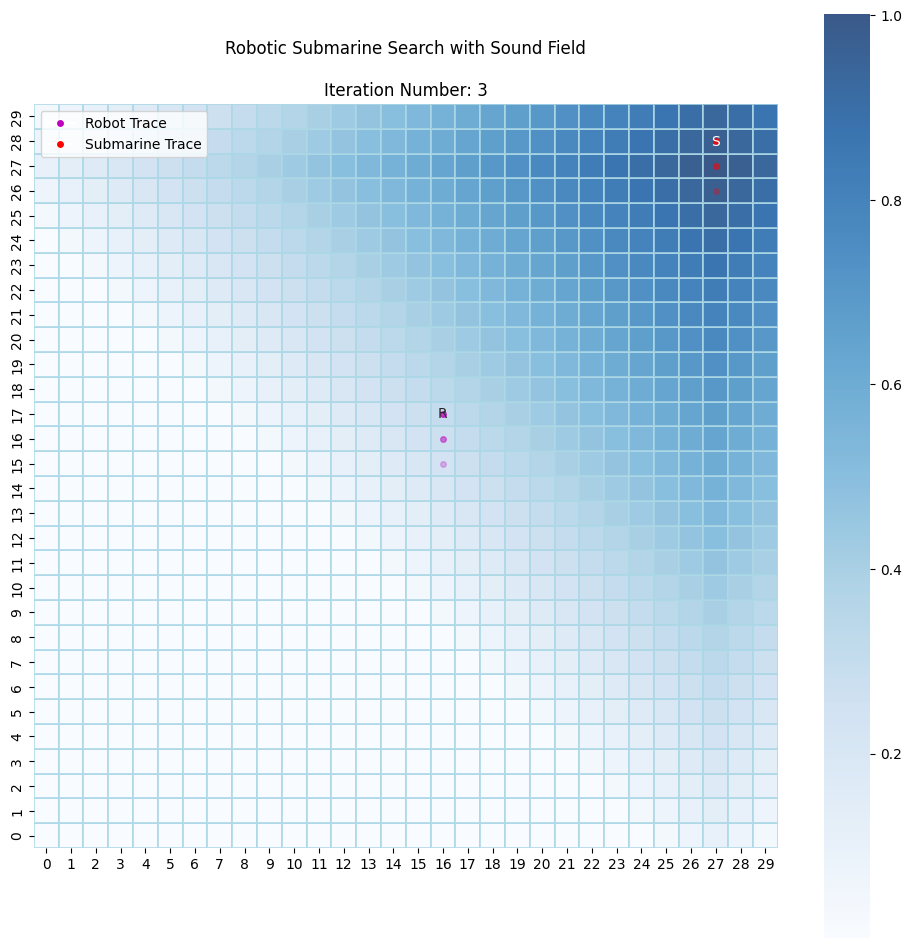

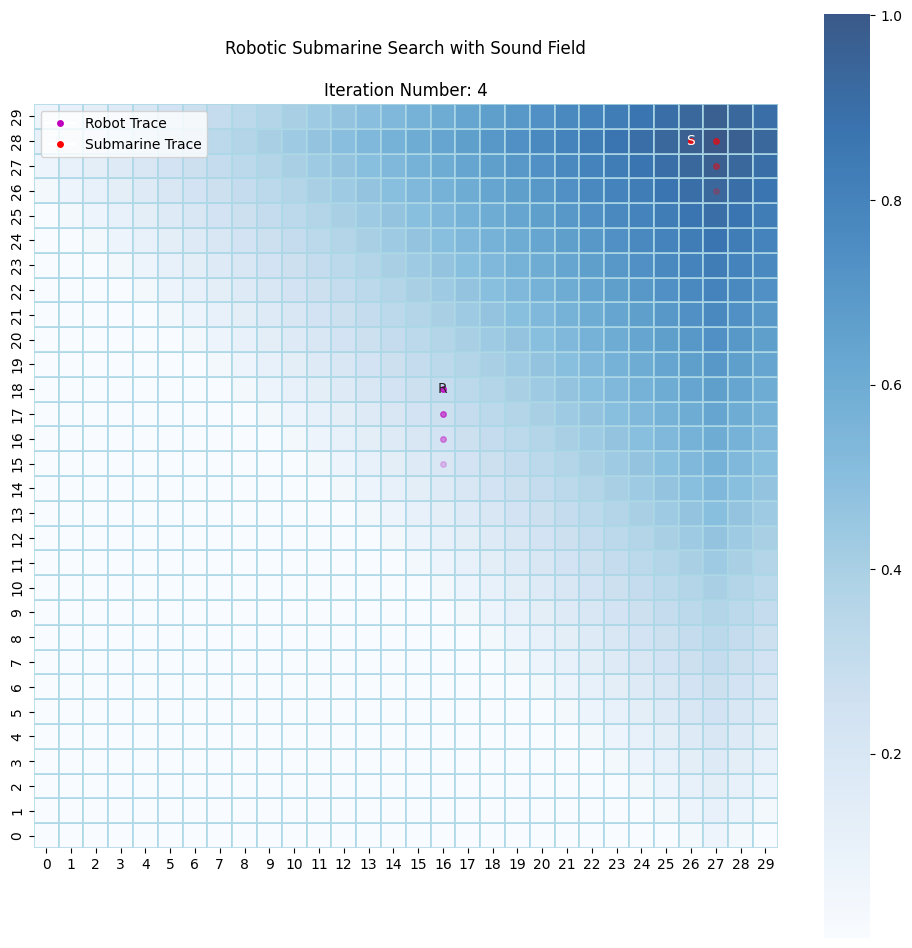

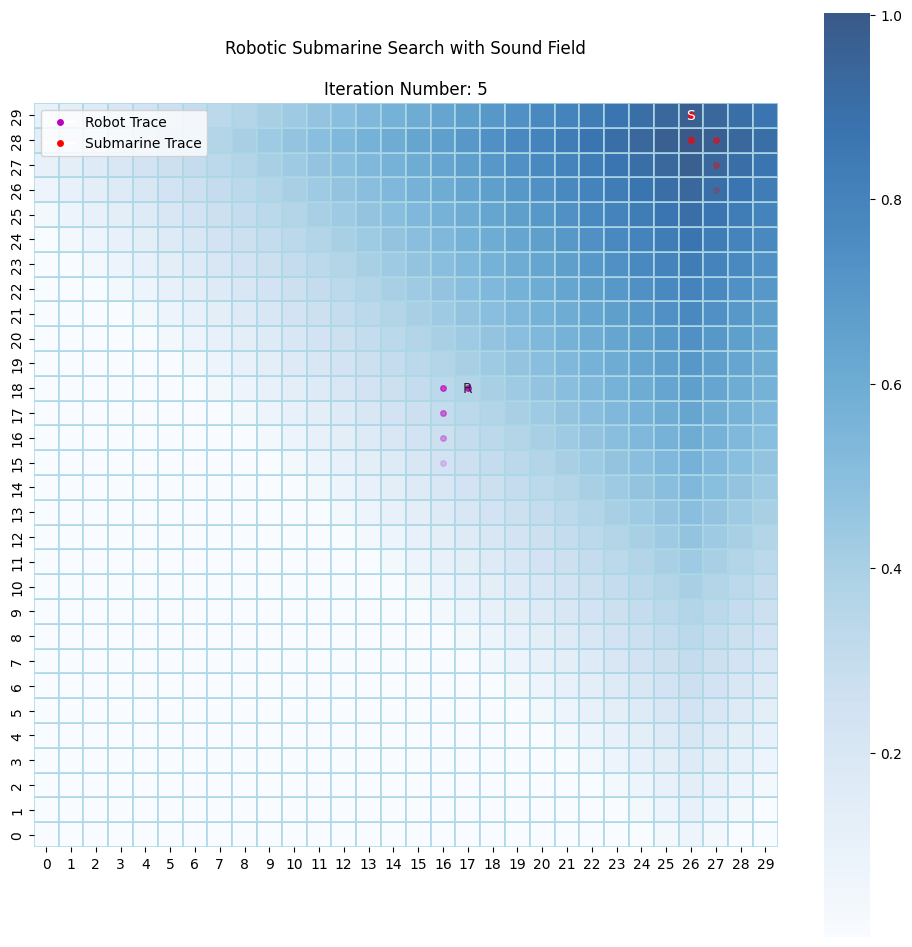

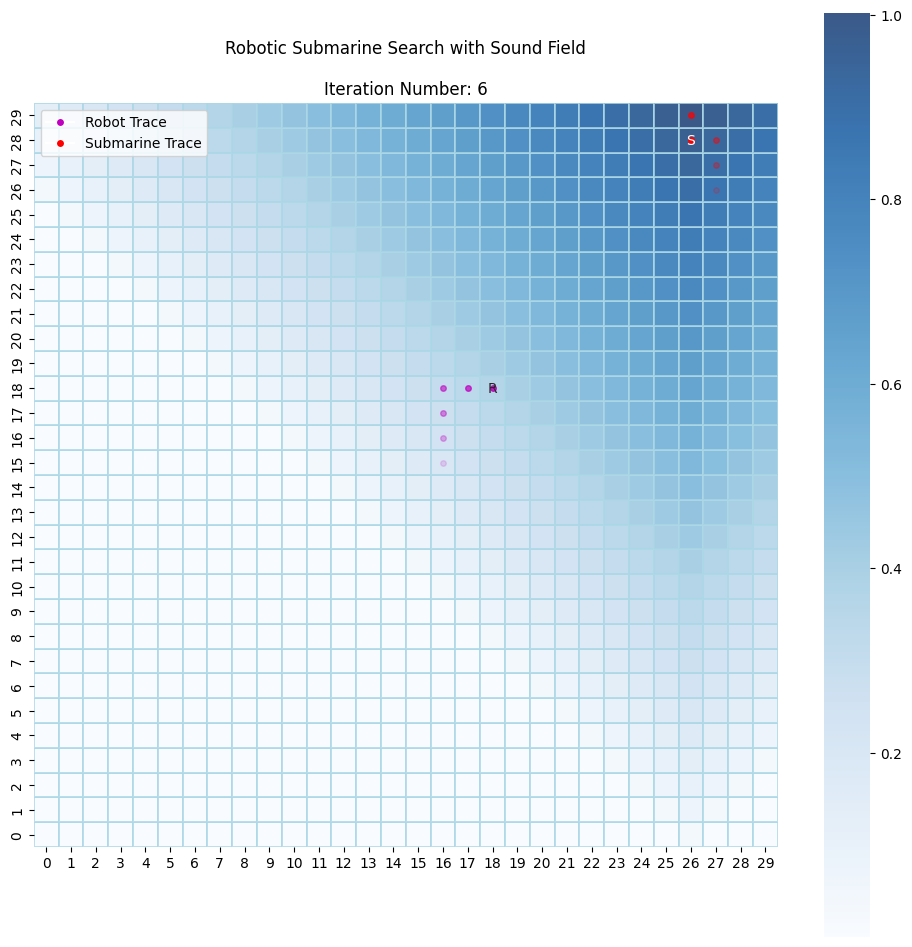

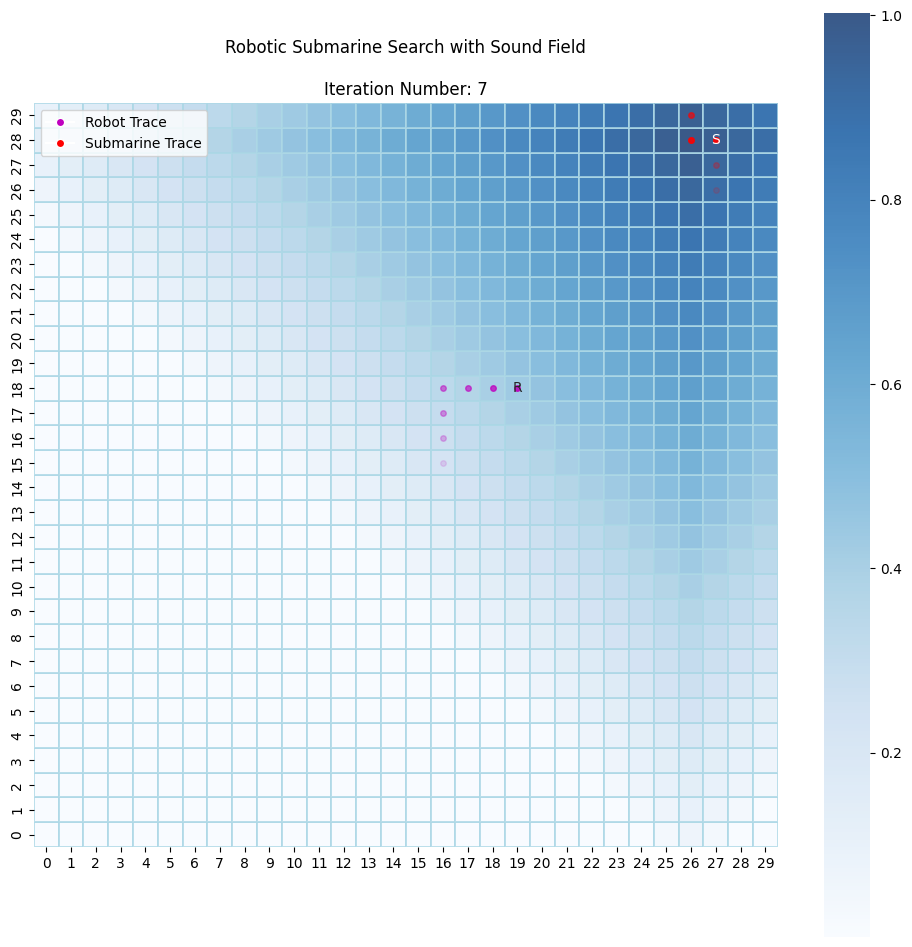

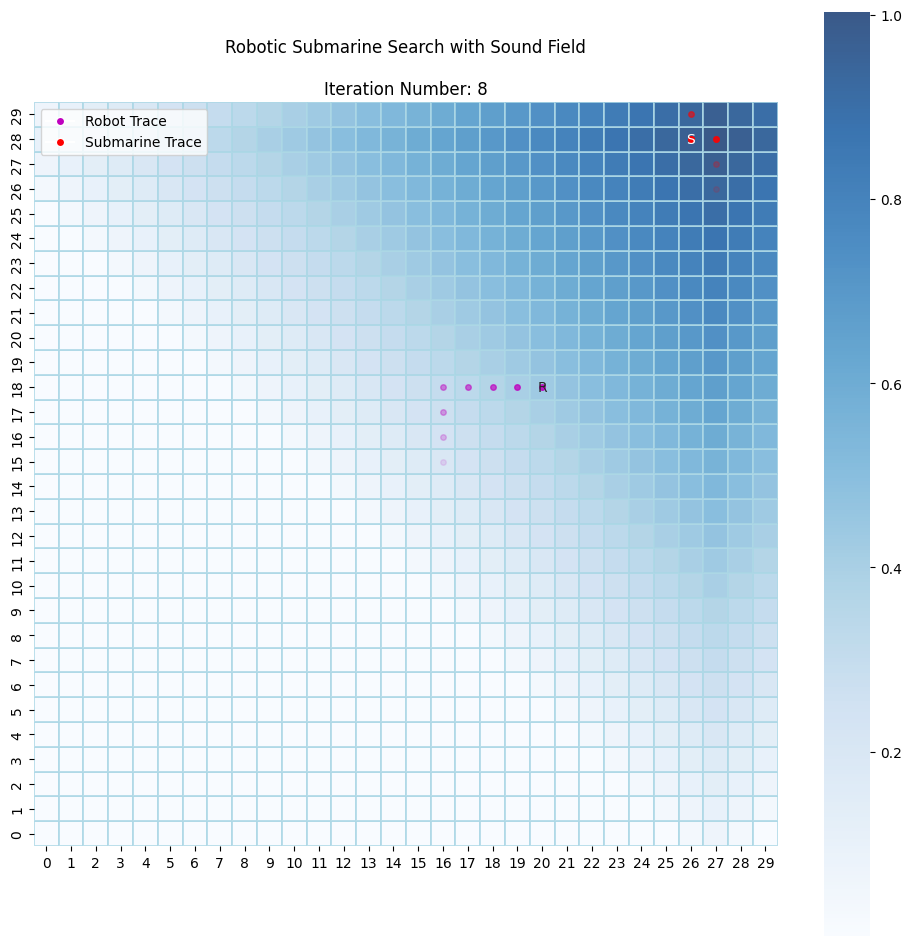

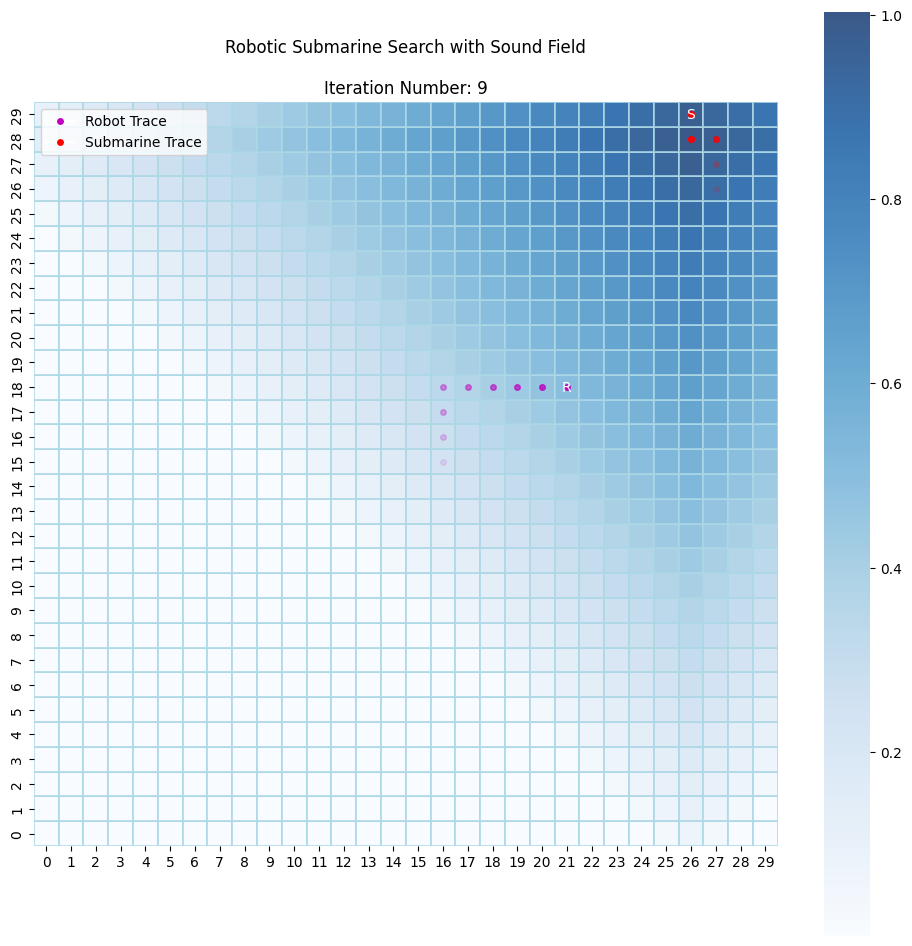

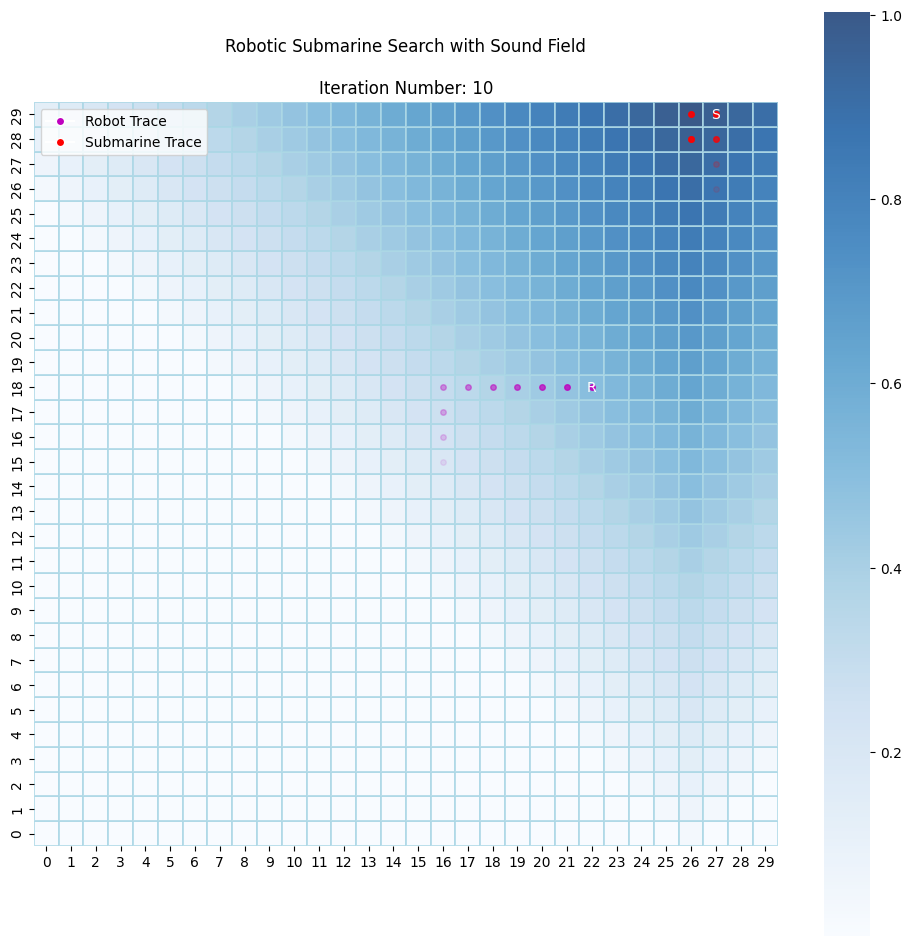

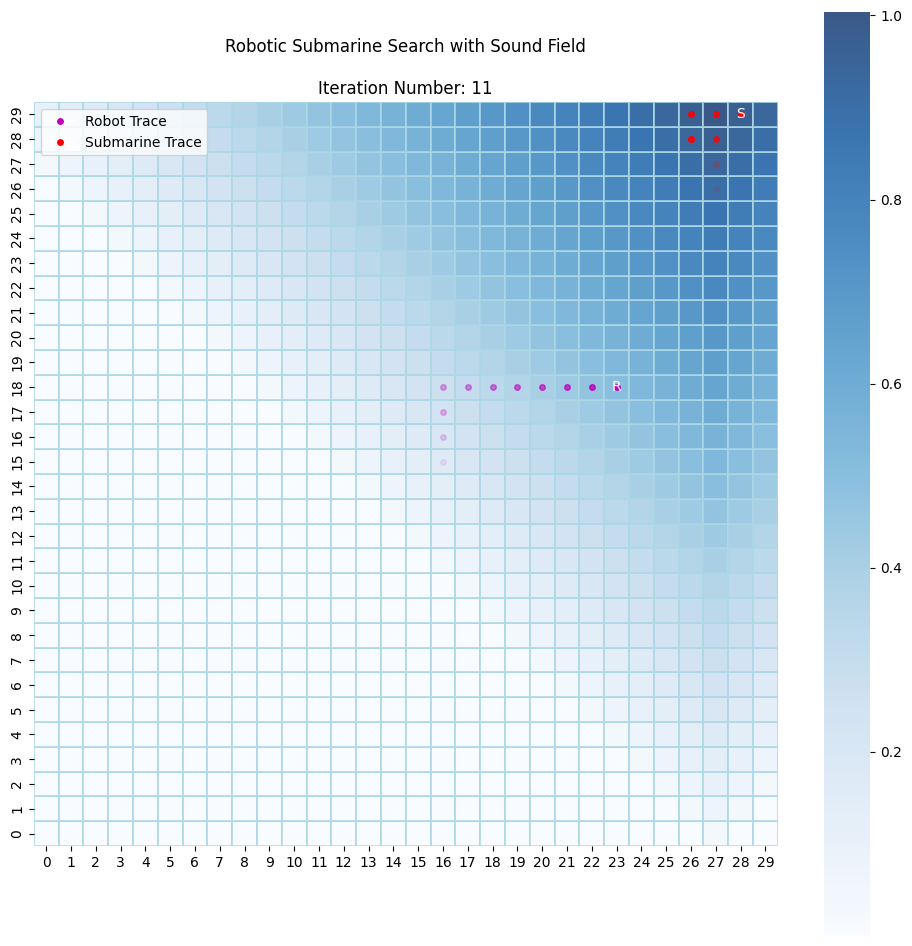

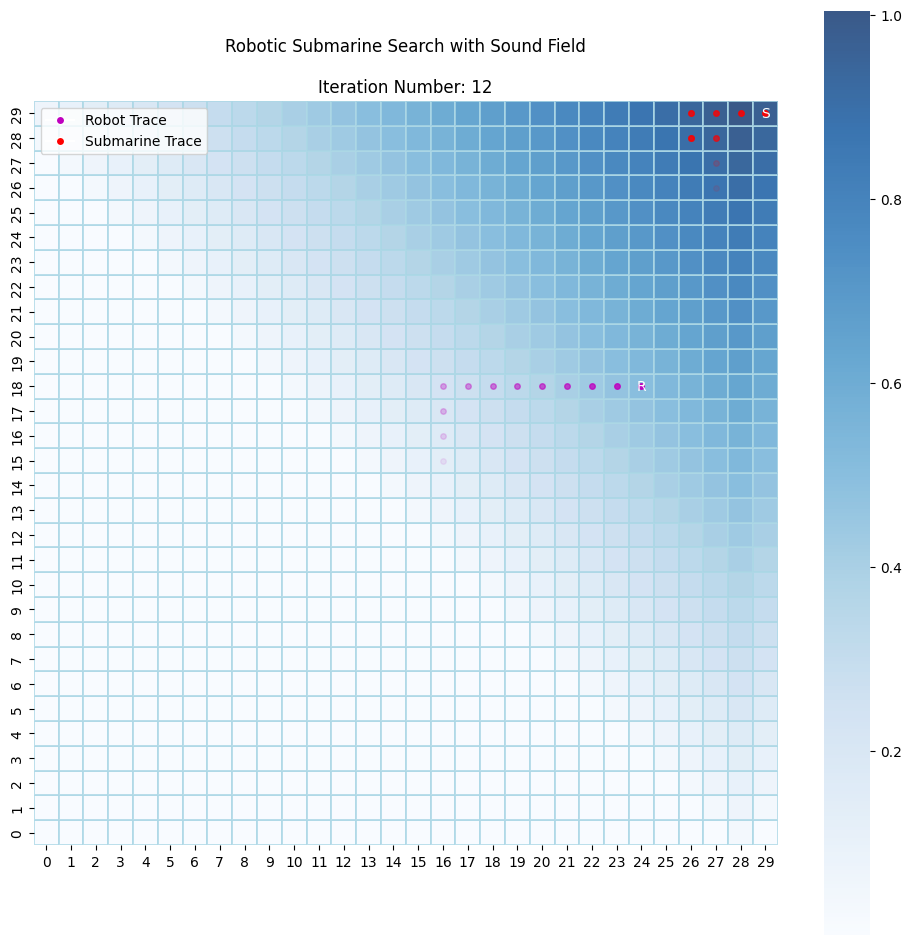

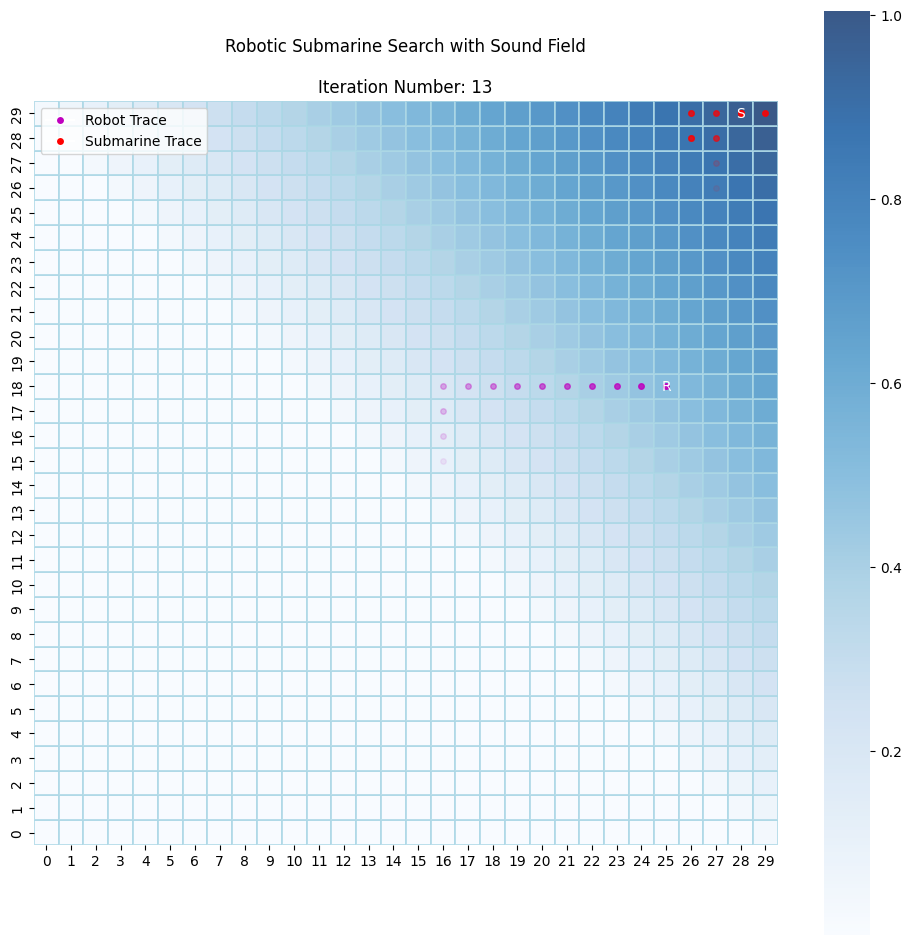

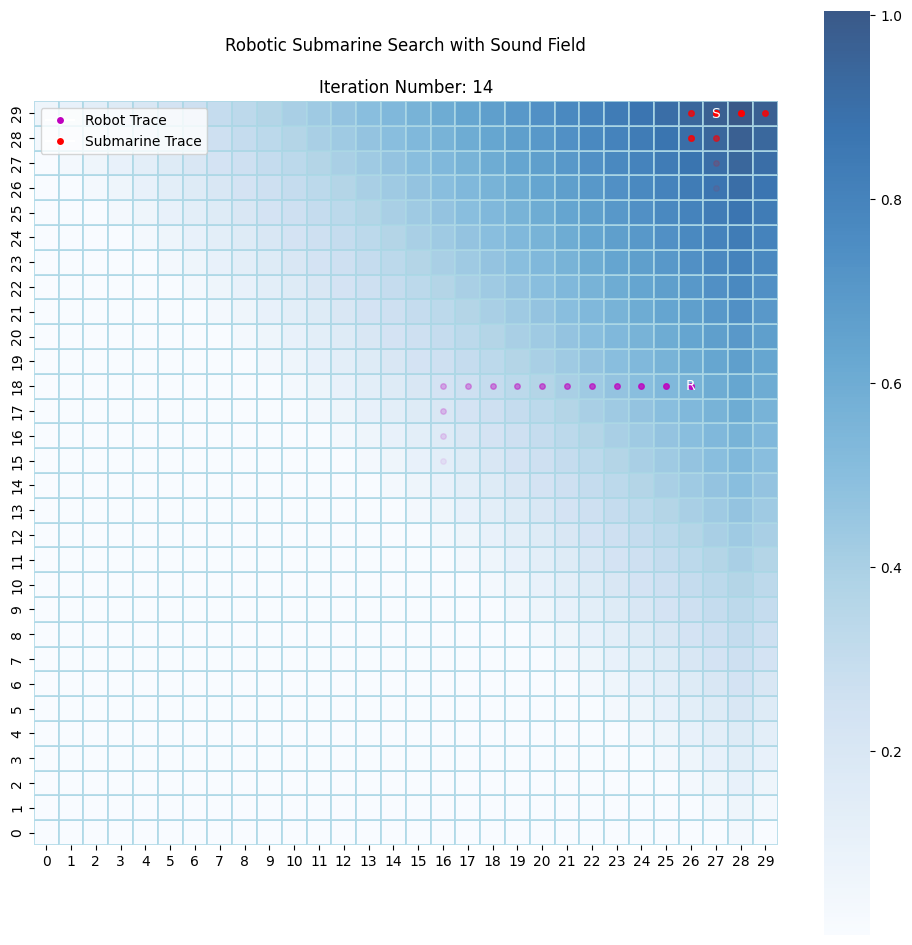

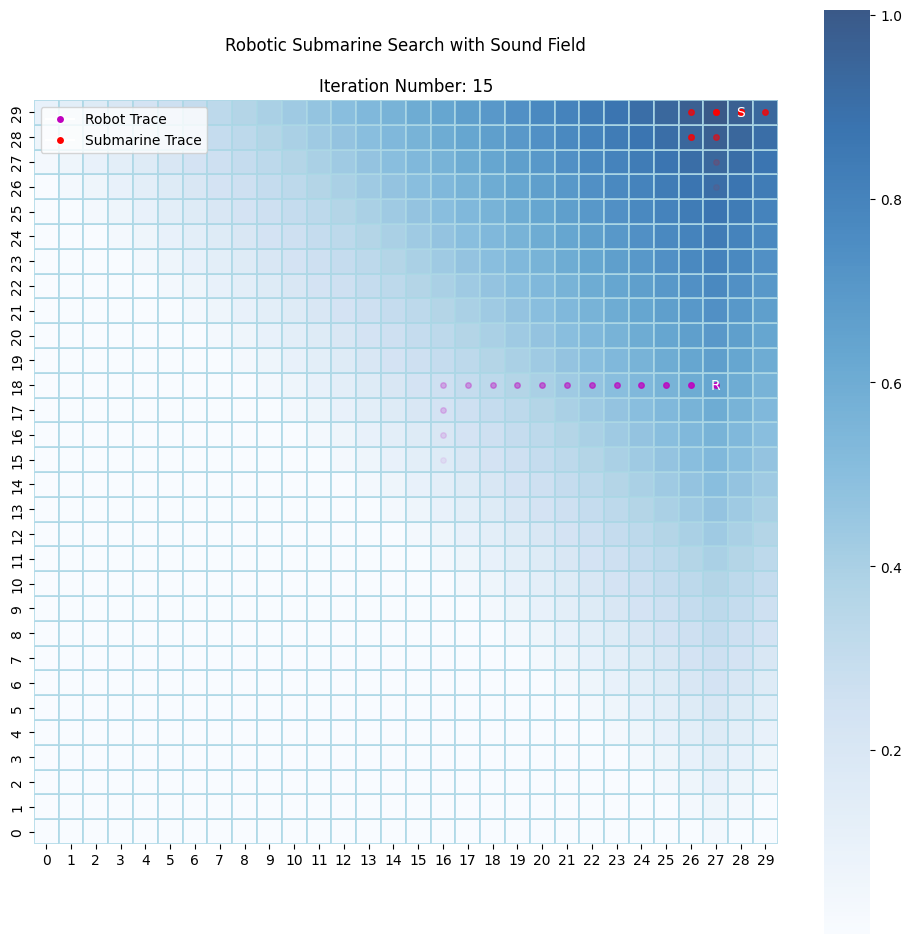

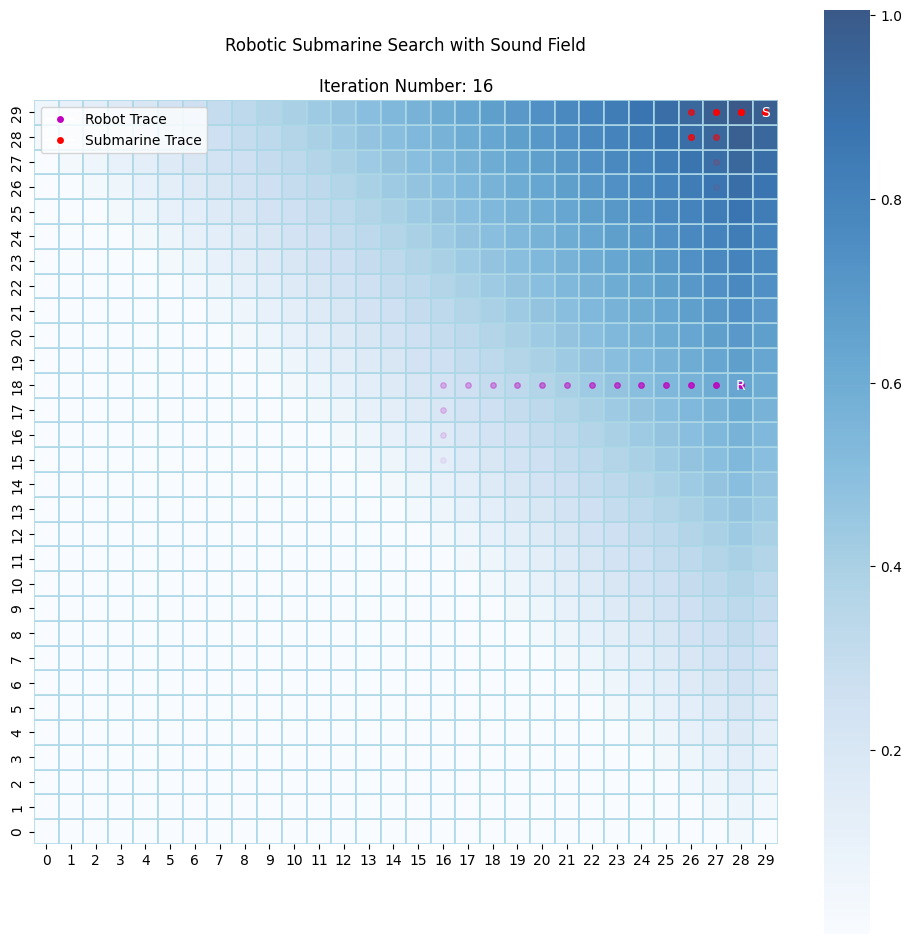

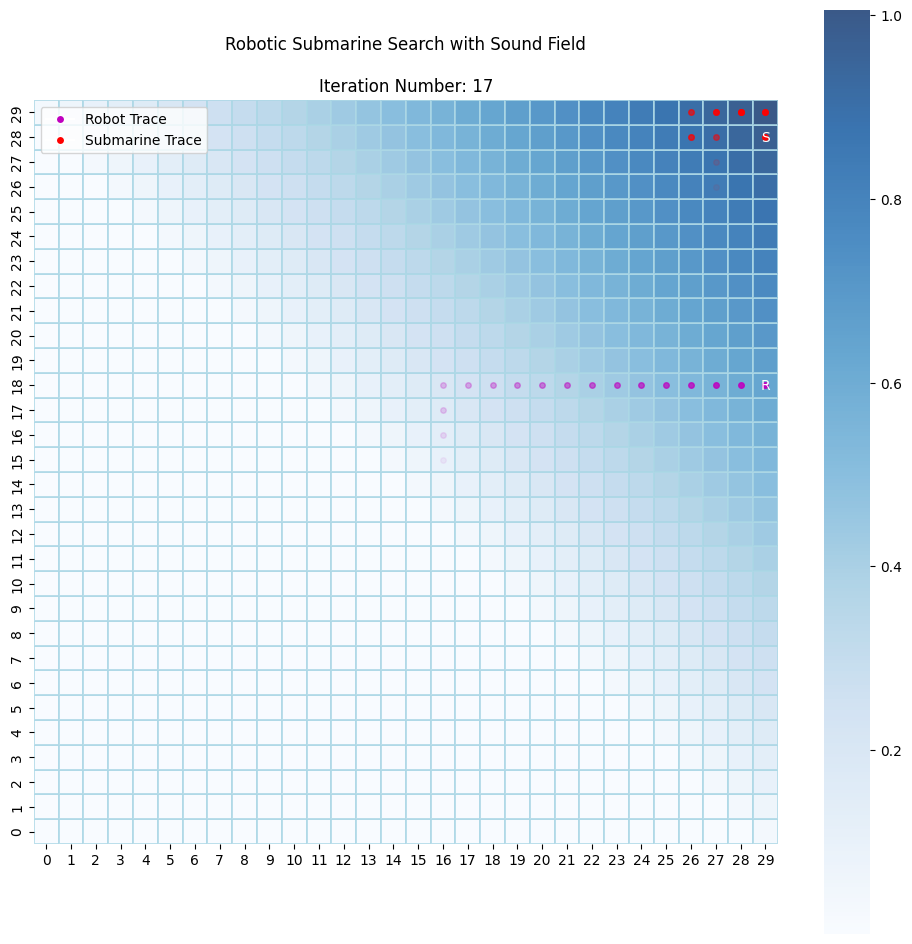

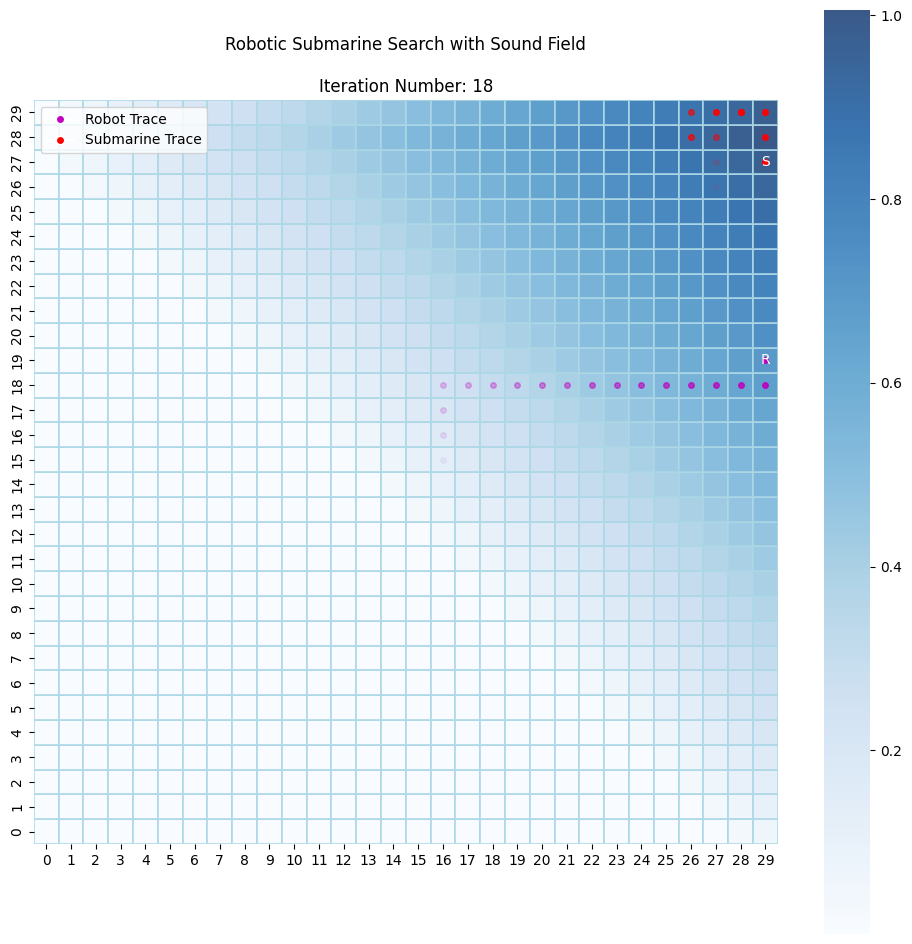

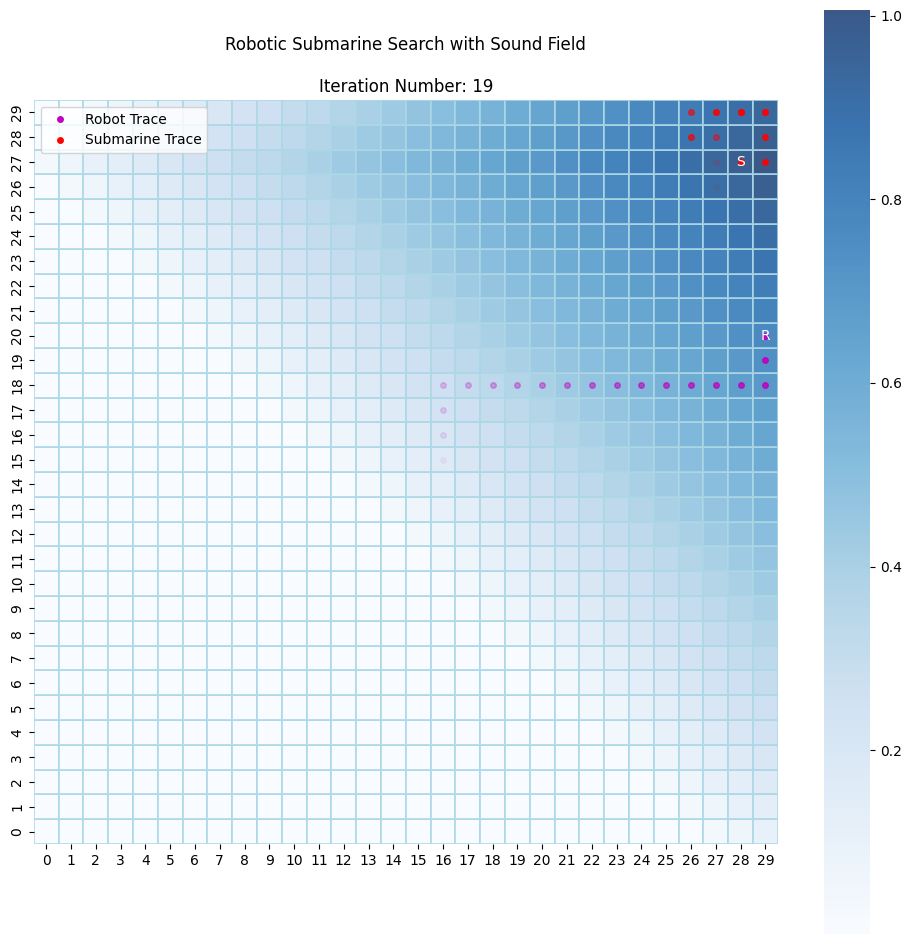

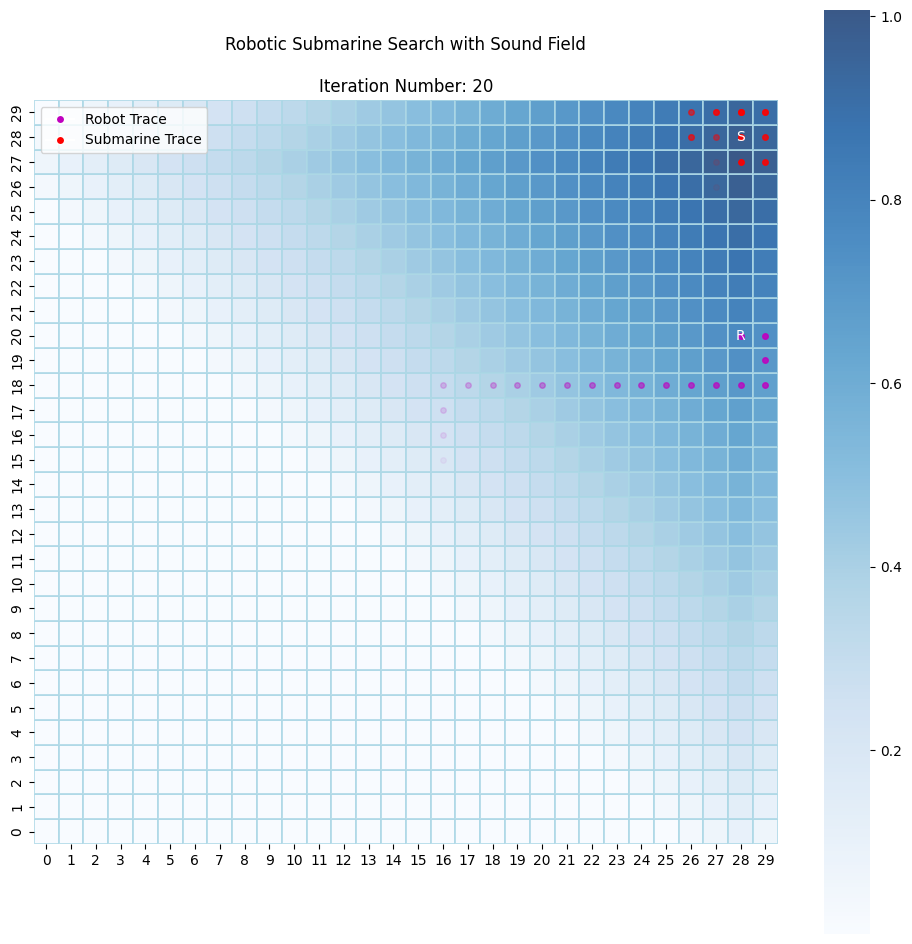

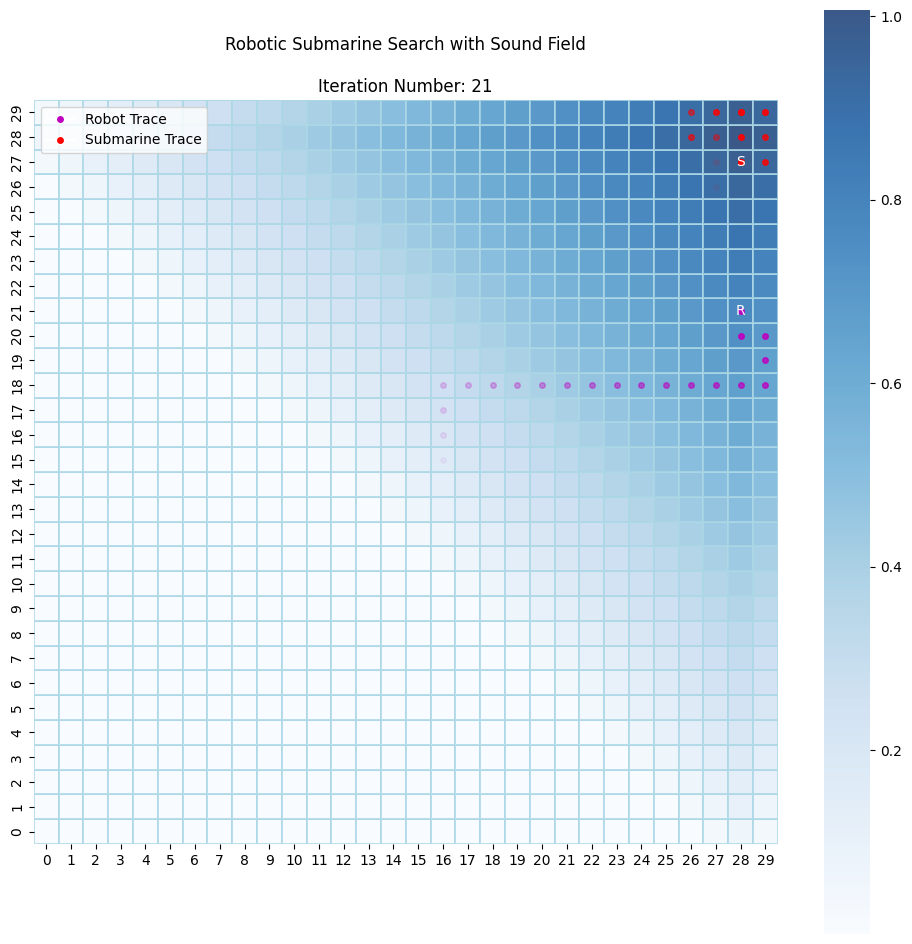

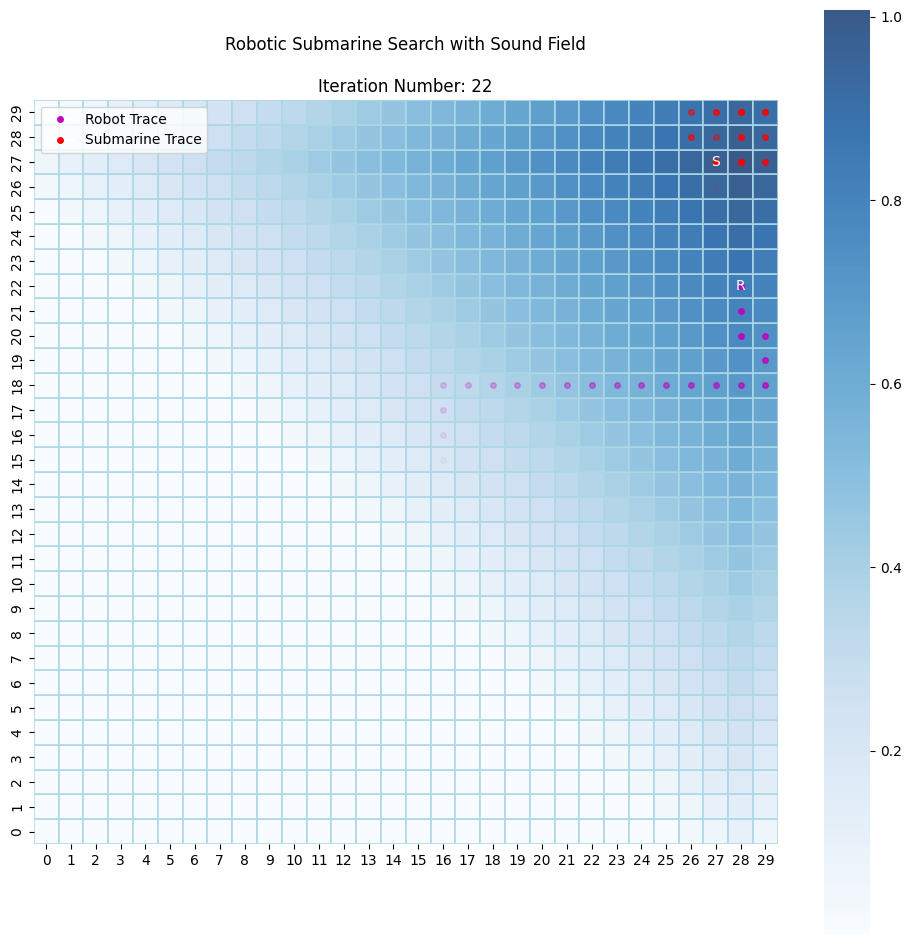

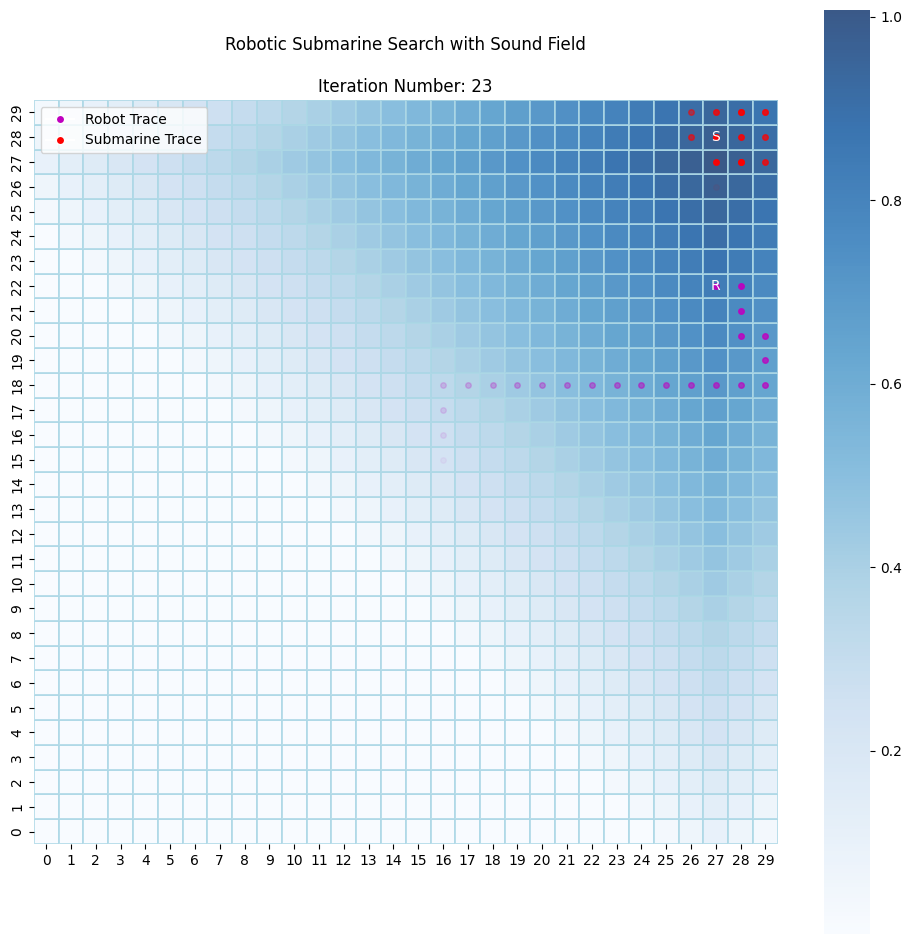

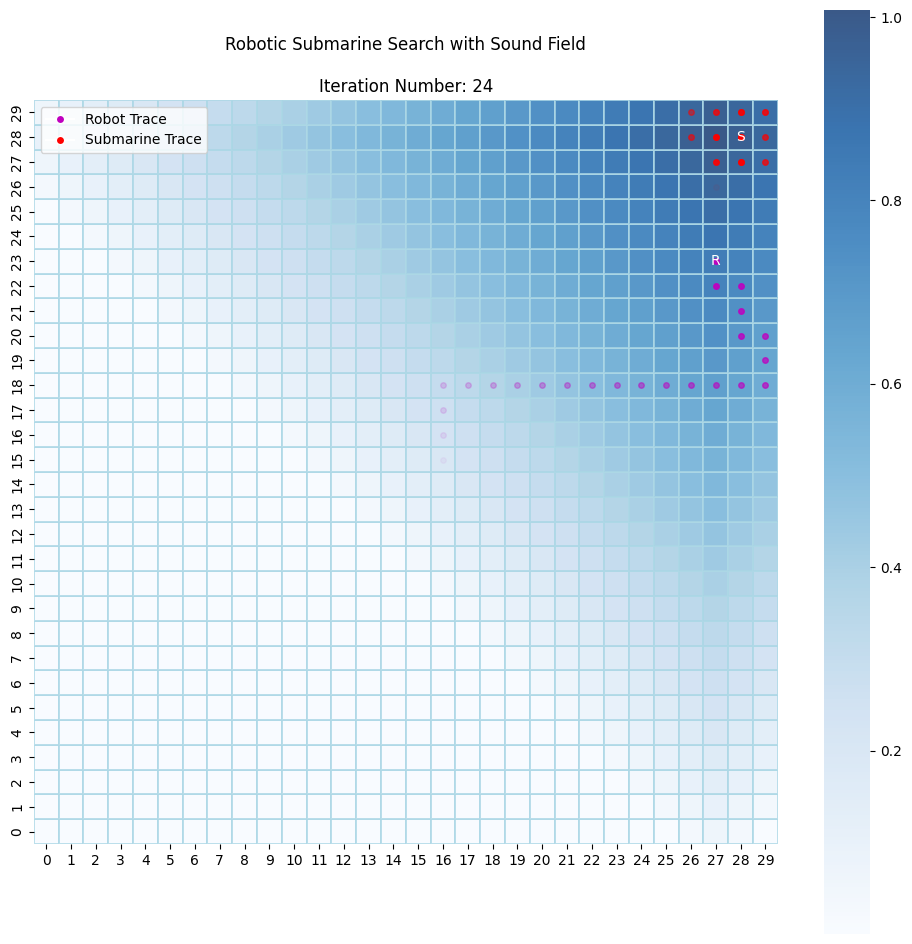

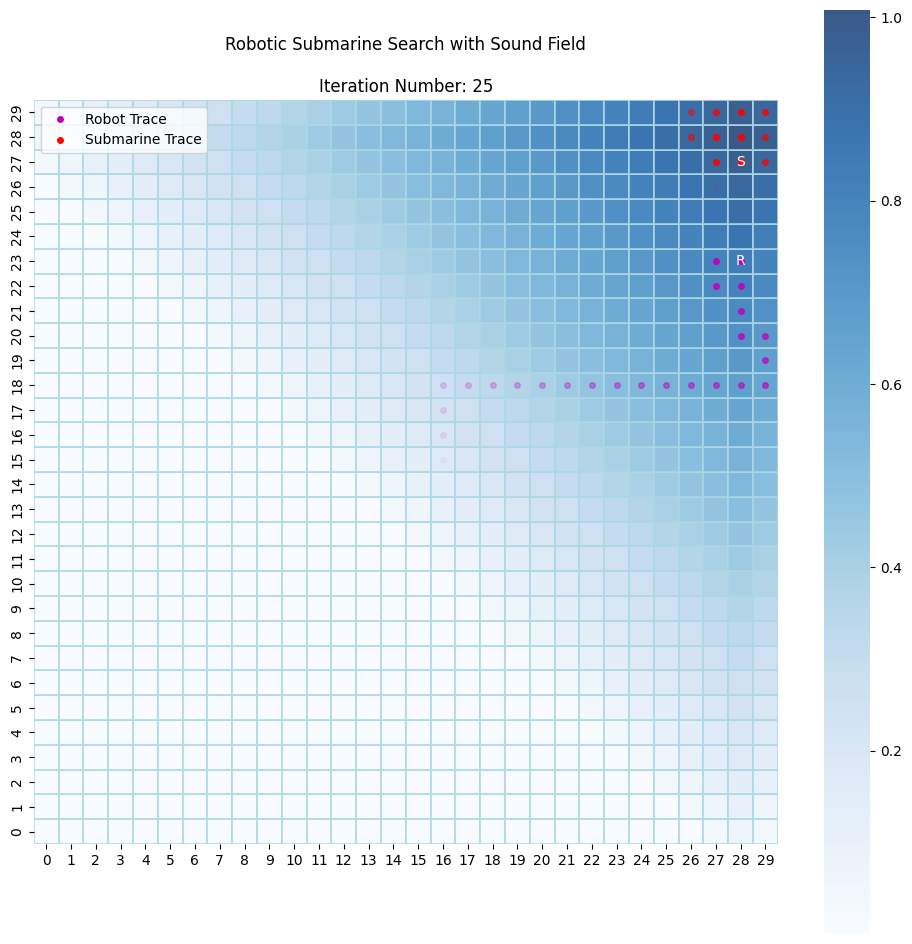

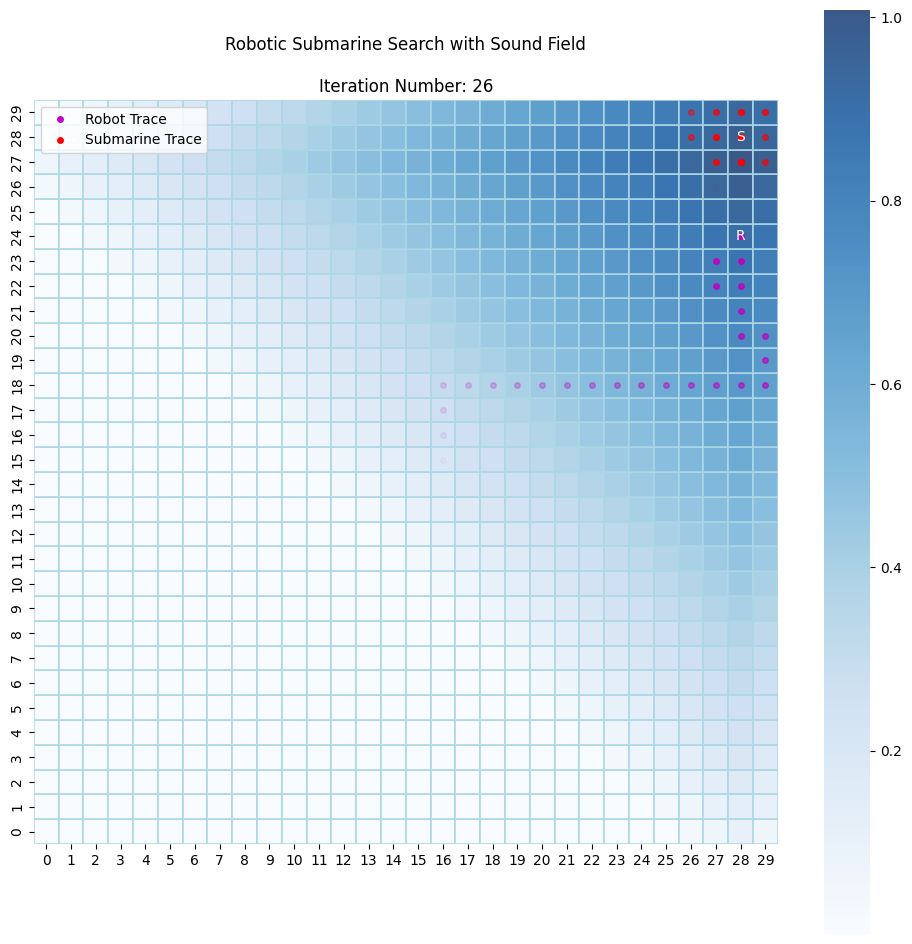

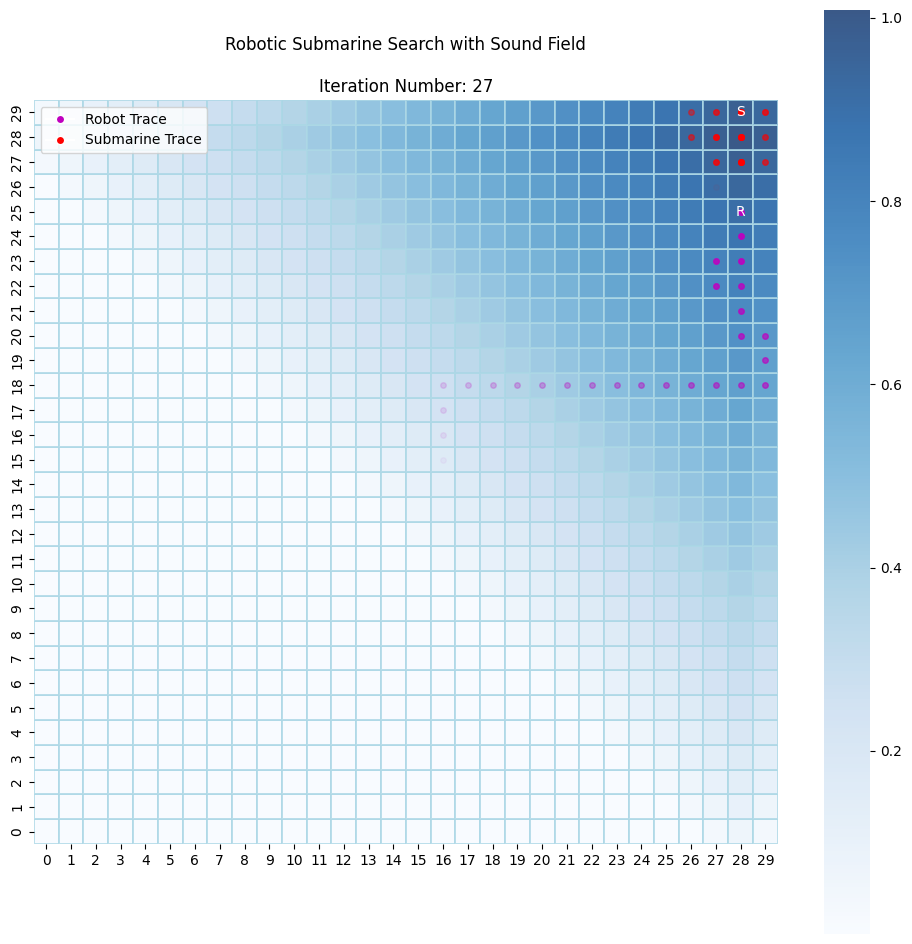

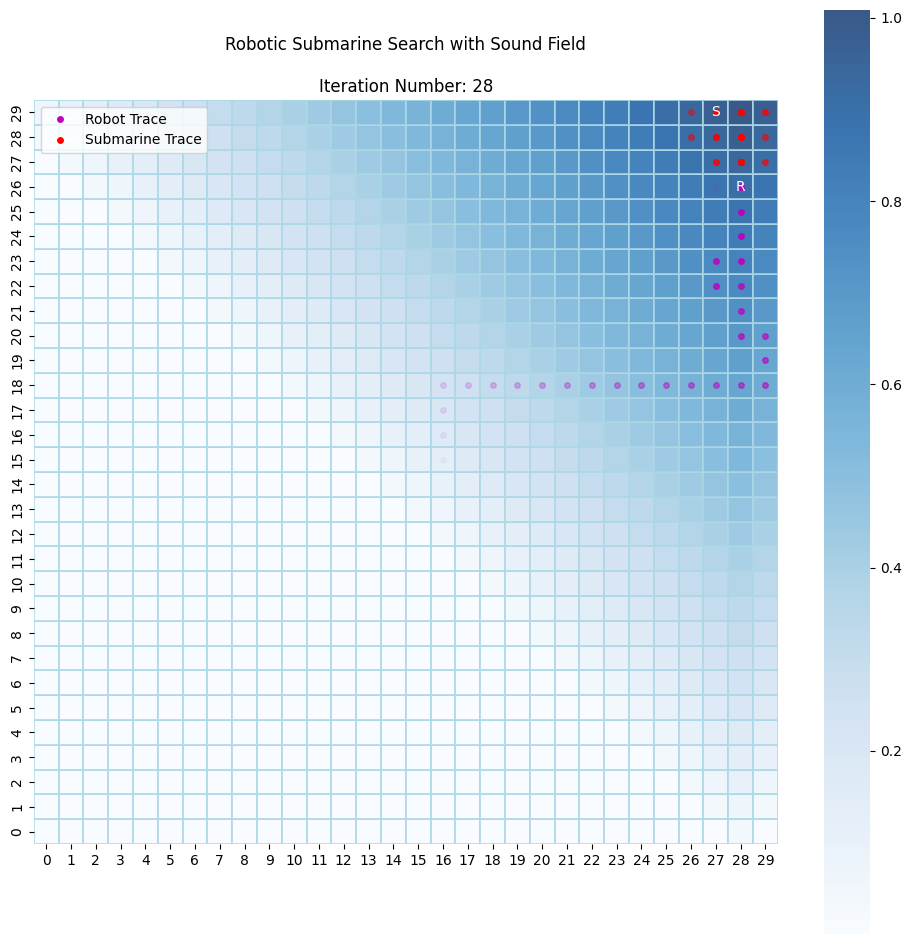

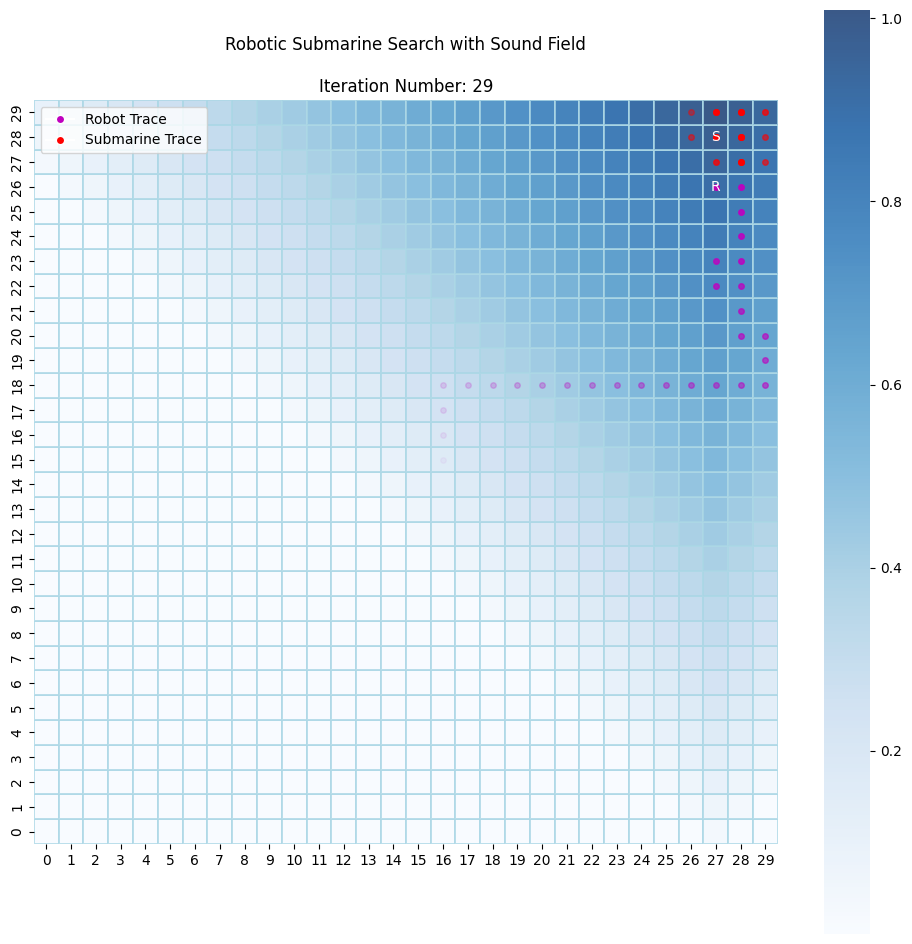

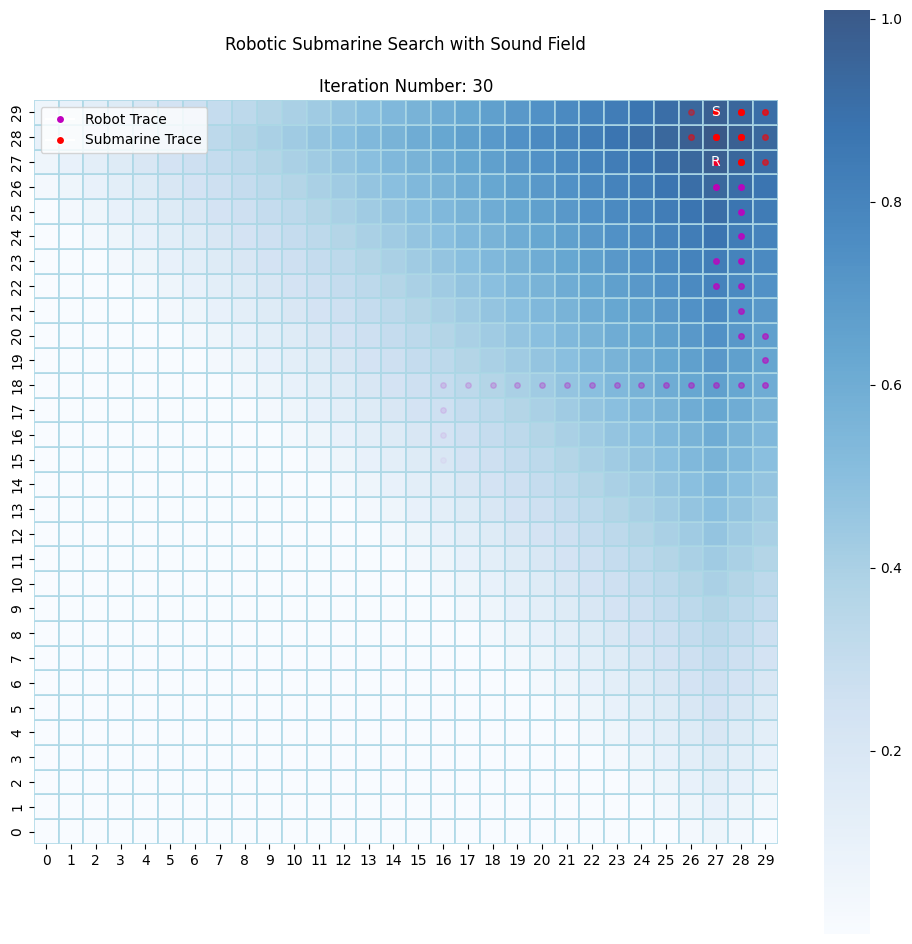

Submarine within detection zone


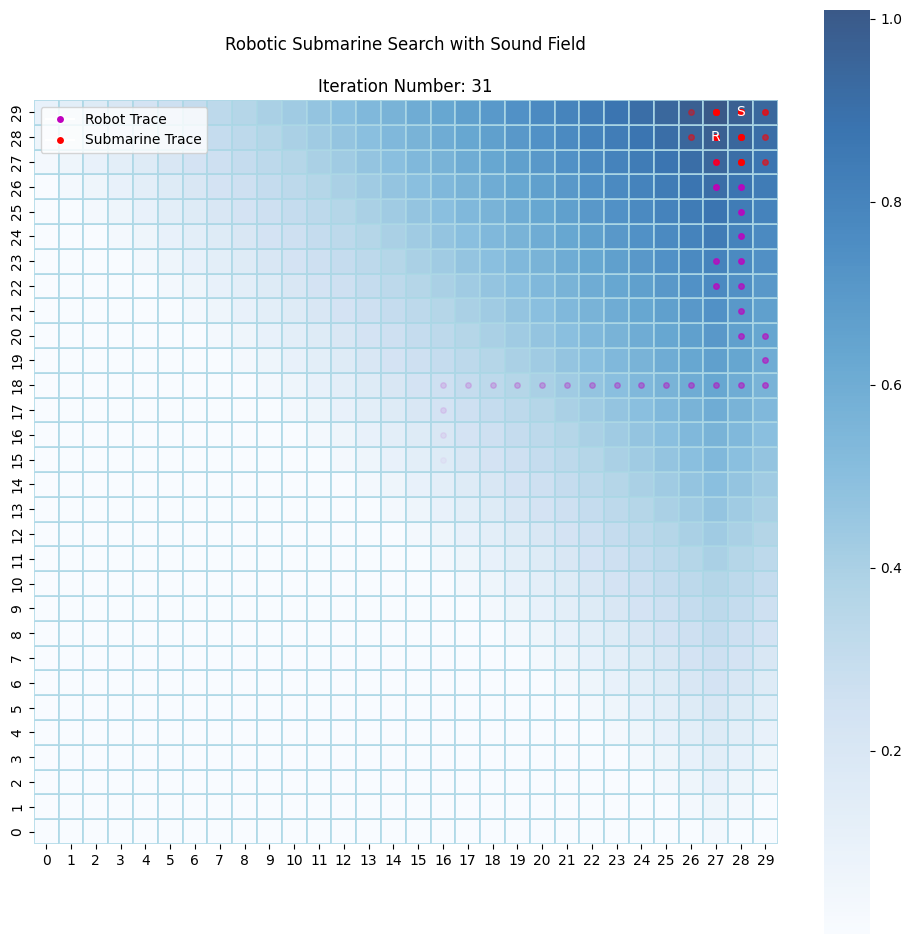

Submarine found on position (29, 28)!


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

# params
grid_size = int(input('Type in grid_size: '))
sound_radius = int(input('Type in sound_radius (recommended to be at least as high as 0.5 * grid_size): '))

# grid and colors
terrain_map = {"Water": "#5bc0de"}
target_color = "#ff5733"
start_color = "#4caf50"

# beliefs and sound field
beliefs = np.full((grid_size, grid_size), 1/(grid_size * grid_size))  # initial uniform beliefs
in_sound_field = False  # to track if robot has entered the sound field

# random starting point for submarine
submarine_position = (random.randint(0, grid_size-1), random.randint(0, grid_size-1))
while True:
    start_x = int(input(f"Enter robot's starting X position (0-{grid_size-1}): "))
    start_y = int(input(f"Enter robot's starting Y position (0-{grid_size-1}): "))
    if (start_x, start_y) != submarine_position:
        start_position = (start_x, start_y)
        break
    print("Starting position cannot be the same as the submarine's position. Please choose again.")

# traces
robot_trace = [start_position]
submarine_trace = [submarine_position]

iter = 0

# viz
def display_grid(beliefs, actual_position, robot_position, sound_field):
    global iter
    iter += 1

    max_sound_value = np.max(sound_field)
    sound_intensity_grid = sound_field / max_sound_value if max_sound_value > 0 else np.zeros_like(sound_field)

    # annotations
    annot_grid = np.full((grid_size, grid_size), "", dtype=object)
    annot_grid[actual_position] = "S"  # Mark submarine position
    annot_grid[robot_position] = "R"    # Mark robot position

    # belief data on the sound field
    combined_grid = sound_intensity_grid + beliefs * 0.5

    # plot sound intensity
    plt.figure(figsize=(12, 12))
    sns.heatmap(
        combined_grid, annot=annot_grid, fmt="", cmap="Blues", cbar=True,
        square=True, linewidths=.2, linecolor='lightblue', alpha=0.8
    )

    # plot robot trace
    for i, (rx, ry) in enumerate(robot_trace):
        color_intensity = i / len(robot_trace)  # Compute intensity for transparency
        plt.plot(ry + 0.5, rx + 0.5, 'mo', markersize=4, alpha=color_intensity,
                label="Robot Trace" if i == 0 else "")  # Add label only for the first trace point

    # plot  submarine trace
    for i, position in enumerate(submarine_trace):
        if isinstance(position, tuple) and len(position) == 2:  # Ensure proper unpacking
            sx, sy = position
            color_intensity = i / len(submarine_trace)  # Compute intensity for transparency
            plt.plot(sy + 0.5, sx + 0.5, 'ro', markersize=4, alpha=color_intensity,
                    label="Submarine Trace" if i == 0 else "")  # Add label only for the first trace point
        else:
            print(f"Invalid submarine trace point: {position}")

    # legend
    robot_legend = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='m', markersize=6, label="Robot Trace")
    submarine_legend = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=6, label="Submarine Trace")
    plt.legend(handles=[robot_legend, submarine_legend])

    plt.title(f"Robotic Submarine Search with Sound Field\n\nIteration Number: {iter}")
    plt.gca().invert_yaxis()
    plt.show()

def generate_sound_field(position):
    field = np.zeros((grid_size, grid_size), dtype=float)
    x, y = position

    # Define a decreasing intensity per layer
    for distance in range(sound_radius + 1):
        layer_value = 1 - (distance/sound_radius)

        for dx in range(-distance, distance + 1):
            for dy in range(-distance, distance + 1):
                if abs(dx) + abs(dy) == distance:  # Only cells exactly at the layer distance
                    if 0 <= x + dx < grid_size and 0 <= y + dy < grid_size:
                        field[x + dx, y + dy] = layer_value

    return field

def move_submarine(position):
    possible_moves = [(0, 1), (1, 0), (0, -1), (-1, 0)]
    random.shuffle(possible_moves)  # Shuffle moves for randomness
    for move in possible_moves:
        new_position = (position[0] + move[0], position[1] + move[1])
        if 0 <= new_position[0] < grid_size and 0 <= new_position[1] < grid_size:
            return new_position
    return position  # No move possible

def is_submarine_found(robot_position, submarine_position):
    return robot_position == submarine_position

# check if the robot is within a 3x3 area of the submarine
def is_within_detection_zone(robot_position, submarine_position):
    rx, ry = robot_position
    sx, sy = submarine_position
    return (sx - 1 <= rx <= sx + 1) and (sy - 1 <= ry <= sy + 1)

# bayesian belief update function
def calculate_likelihood(sound_field):
    likelihood = np.exp(-0.5 * (1 - sound_field)**2)  # Gaussian likelihood
    likelihood /= np.sum(likelihood)  # Normalize
    return likelihood

# update beliefs based on sound field using Bayesian theory
def update_beliefs(beliefs, sound_field):
    likelihood = calculate_likelihood(sound_field)  # likelihood from the sound field
    updated_beliefs = beliefs * likelihood  # element-wise multiplication of priors and likelihoods
    updated_beliefs /= np.sum(updated_beliefs)  # normalize to maintain total probability of 1
    return updated_beliefs

# --- Expected Gain  ---
def calculate_entropy(beliefs):
    return -np.sum(beliefs * np.log(beliefs + 1e-9))  # add small value to avoid log(0)

def simulate_belief_update(beliefs, action, sound_field):
    dx, dy = {
        "up": (-1, 0), "down": (1, 0),
        "left": (0, -1), "right": (0, 1)
    }[action]
    new_beliefs = np.roll(beliefs, shift=(dx, dy), axis=(0, 1))
    return update_beliefs(new_beliefs, sound_field)

def calculate_expected_gain(beliefs, actions, sound_field, robot_position):
    gains = {}
    x, y = robot_position
    for action in actions:
        dx, dy = {
            "up": (-1, 0), "down": (1, 0),
            "left": (0, -1), "right": (0, 1)
        }[action]

        # bew potential position
        new_x, new_y = x + dx, y + dy
        if 0 <= new_x < grid_size and 0 <= new_y < grid_size:
            # base gain from sound intensity
            sound_intensity_gain = sound_field[new_x, new_y]

            # add penalty if moving away from the current sound intensity
            penalty = 0.1 * max(0, sound_field[x, y] - sound_intensity_gain)
            gain = sound_intensity_gain - penalty

            # entropy reduction based on beliefs
            simulated_beliefs = simulate_belief_update(beliefs, action, sound_field)
            entropy_after_action = calculate_entropy(simulated_beliefs)

            gain -= entropy_after_action

            gains[action] = gain

    # return the action with the highest calculated gain
    best_action = max(gains, key=gains.get)
    return best_action

# --- Main Simulation Loop ---
while True:
    # generate sound field based on submarine's current position
    sound_field = generate_sound_field(submarine_position)

    # update beliefs based on the sound field
    beliefs = update_beliefs(beliefs, sound_field)

    # select the best move based on expected gain
    actions = ["up", "down", "left", "right"]
    next_action = calculate_expected_gain(beliefs, actions, sound_field, robot_trace[-1])

    # translate the best action to a new position
    dx, dy = {
        "up": (-1, 0), "down": (1, 0),
        "left": (0, -1), "right": (0, 1)
    }[next_action]
    next_position = (robot_trace[-1][0] + dx, robot_trace[-1][1] + dy)

    # update robot trace and position
    robot_trace.append(next_position)

    # move submarine randomly
    submarine_position = move_submarine(submarine_position)
    submarine_trace.append(submarine_position)

    # check if the robot found the submarine
    if is_submarine_found(next_position, submarine_position):
        print(f"\n\nSubmarine found on position {submarine_position}!")
        break

    # check if the robot is withing detection zone, so we won't end up chasing submaring endlessly
    if is_within_detection_zone(next_position, submarine_position):
        print('Submarine within detection zone')
        display_grid(beliefs, submarine_position, next_position, sound_field)
        print(f'Submarine found on position {submarine_position}!')
        break

    # display the updated grid and belief system
    display_grid(beliefs, submarine_position, next_position, sound_field)